In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def ratios(vec): 
    return([vec[0]/vec[1],vec[2]/vec[3]])

In [3]:
def cross_auto_spectra(inp,out): # returns [S_io, S_ii, S_oo, S_oi]
    sig=[inp,out]
    ind=[[0,1],[0,0],[1,1],[1,0]]
    return np.array([np.conj(sig[i])*sig[j] for i,j in ind])

In [4]:
def derivative(frf,freq,n):
    return(frf*(2j*np.pi*freq)**n)   

In [5]:
def generate_acc_frfs(file_name, sensor_range, double_impact_threshold = 5, low_freq = 100, high_freq = 10000):
    file_data = np.load(file_name, allow_pickle = True)
    n_impacts = len(file_data)
    N = file_data[0]['samples'] # number of samples
    dt = file_data[0]['dt'] # sampling time
    
    all_spectra = 0

    for impact in range(n_impacts):
        time_signals = file_data[impact]['data'].T
        
        f = time_signals[0] # force time signal
        
        # change directions
        x = ((time_signals[1:][output_ind]).T*output_sign).T
        
        if np.all(np.max(np.abs(time_signals), axis = 1)<np.asarray(sensor_range)): # check sensor range
            i_max=np.argmax(f); # max value index
            i_low=np.copy(i_max) # right before impact there is typically liitle drop in force measurements
            while f[i_low]>=f[i_low-1]: i_low-=1
            i_high_1=np.copy(i_max) # option 1 - impulse ends when 0 value is reached
            while f[i_high_1]>=0.: i_high_1+=1
            i_high_2=np.copy(i_max) # option 2 - impulse ends when signal starts rising
            while f[i_high_2]>=f[i_high_2+1]: i_high_2+=1
            i_high=min([i_high_1,i_high_2])

            if np.max(np.abs(f[i_high:])) < double_impact_threshold: # check for double impact
                w_f=np.zeros(N)
                w_f[i_low:i_high]=1. # force window
                f_w=w_f*f*input_sign_i

                # Fourier transform
                freq=np.fft.rfftfreq(N,d=dt)
                F = np.fft.rfft(f_w)*2
                X = [np.fft.rfft(_)*2 for _ in x] 
                               
                channel_spectra = np.array([cross_auto_spectra(F,X_i) for X_i in X])
                all_spectra += channel_spectra
            else: print('Double Impact')
        else: print('Sensor Overload.') 

    H_1 = all_spectra[:,0,:]/all_spectra[:,1,:]
    H_2 = all_spectra[:,2,:]/all_spectra[:,3,:]
    
    # Accelerance
    freq = freq[low_freq:high_freq]
    H_1 = H_1[:,low_freq:high_freq]      
    H_2 = H_2[:,low_freq:high_freq]
    
    coh = np.abs(H_1/H_2)
    return (freq,H_1)      

In [6]:
def generate_las_frfs(file_name, sensor_range, double_impact_threshold = 5, low_freq = 100, high_freq = 10000):
    file_data = np.load(file_name, allow_pickle = True)
    n_impacts = len(file_data)
    N = file_data[0]['samples'] # number of samples
    dt = file_data[0]['dt'] # sampling time
    
    all_spectra = 0

    for impact in range(n_impacts):
        time_signals = file_data[impact]['data'].T
        
        f = time_signals[0] # force time signal 
        x = time_signals[1]
        las_sign = -1
        x = (x - np.average(x[:50]))*las_sign # pri laserju včasih statični odmik?
        
        if np.all(np.max(np.abs(time_signals), axis = 1)<np.asarray(sensor_range)): # check sensor range
            i_max=np.argmax(f); # max value index
            i_low=np.copy(i_max) # right before impact there is typically liitle drop in force measurements
            while f[i_low]>=f[i_low-1]: i_low-=1
            i_high_1=np.copy(i_max) # option 1 - impulse ends when 0 value is reached
            while f[i_high_1]>=0.: i_high_1+=1
            i_high_2=np.copy(i_max) # option 2 - impulse ends when signal starts rising
            while f[i_high_2]>=f[i_high_2+1]: i_high_2+=1
            i_high=min([i_high_1,i_high_2])

            if np.max(np.abs(f[i_high:])) < double_impact_threshold: # check for double impact
                w_f=np.zeros(N)
                w_f[i_low:i_high]=1. # force window
                f_w=w_f*f*input_sign_i
                # Fourier transform
                freq=np.fft.rfftfreq(N,d=dt)
                F = np.fft.rfft(f_w)*2
                X = np.fft.rfft(x)*2
                               
                channel_spectra = cross_auto_spectra(F,X)
                all_spectra += channel_spectra
            else: print('Double Impact: out_loc ' + str(output_loc) + ', inp_loc' + str(impact_loc))
        else: print('Sensor Overload.') 

    H_1 = all_spectra[0]/all_spectra[1,]
    H_2 = all_spectra[2]/all_spectra[3]
    
    # Mobility to accelerance
    freq = freq[low_freq:high_freq]
    H_1 = derivative(H_1[low_freq:high_freq], freq, 1)      
    H_2 = derivative(H_2[low_freq:high_freq], freq, 1)
    
    # Time delay correction
    t0 = 62.5*dt
    H_1 = H_1*np.exp(2j*np.pi*freq*t0)
    
    coh = np.abs(H_1/H_2)
    return (freq,H_1)  

In [7]:
# MERITVE - POSPEŠKOMERI
output_ind = [1,0,2,
              4,3,5,
              7,6,8,
              10,9,11,
              14,12,13]

output_sign = [
    +1,+1,-1,
    +1,+1,-1,
    +1,+1,-1,
    +1,+1,-1,
    -1,-1,+1]

input_ind = [0,1,2,0]

input_sign = [-1,1,-1,-1]

max_voltage = 4999 # mV
sensitivity = np.array([2.273*9.81, 98.88,99.77,103.30,101.53,105.26,100.45,100.55,101.04,98.79,101.24,100.65,103.89,10.17,9.89,10.05])
sensor_range = max_voltage/(sensitivity/9.81)

###########################
frfs_acc = []
for impact_loc in np.arange(4)+1:
    file_name = 'Noneacc_i_' + str(impact_loc) +'.npy' 
    input_sign_i = input_sign[-1 + impact_loc]
    freq_acc, frf_i = generate_acc_frfs(file_name, sensor_range)
    frfs_acc.append(frf_i)

frfs_acc = np.array(frfs_acc)

Sensor Overload.
Sensor Overload.


(0.01, 40.0)

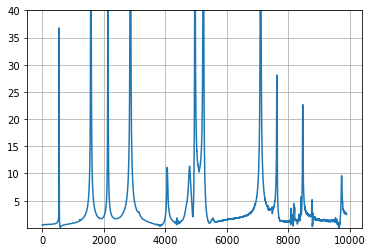

In [8]:
plt.plot(np.abs(frfs_acc[0][0]))
plt.grid()
plt.ylim(0.01, 40)

In [9]:
# MERITVE - LASER
sensor_range = [2000,0.1]
las_point_ind = np.delete(np.arange(28)+1,np.array([1,10,19])-1)
frfs_las = []

###########################
for output_loc in las_point_ind:
    for impact_loc in np.arange(4)+1:
        file_name = 'Nonelas_t'+ str(output_loc)+'_i' + str(impact_loc) +'.npy' 
        input_sign_i = input_sign[-1 + impact_loc]
        freq_las,frf_i = generate_las_frfs(file_name, sensor_range)
        frfs_las.append(frf_i)
        
frfs_las = np.array(frfs_las)

Sensor Overload.
Double Impact: out_loc 16, inp_loc3
Double Impact: out_loc 18, inp_loc3
Double Impact: out_loc 21, inp_loc3
Sensor Overload.


In [10]:
# GEOMETRY
from ts_funkcije import*

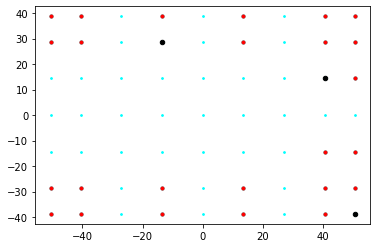

In [11]:
# LASER COUPLING COORDINATES
las_opt = 2 # 1...xyz , 2...z only
if las_opt == 1: c_las = 'blue'
elif las_opt == 2: c_las = 'red'

# koordinate na ploščici
x_all = np.array([50.59,40.59, 27.06, 13.53,   0.  ,  -13.53,  -27.06,  -40.59, -50.59])
y_all = np.array([-38.76, -28.76, -14.38,   0.  ,  14.38,  28.76,  38.76])
plot_points1 = np.array([[x,y,-8] for x in x_all for y in y_all])

x_all = np.array([50.59,40.59, 13.53,  -13.53,  -40.59, -50.59])
y_all = np.array([-38.76, -28.76, -14.38, 14.38,  28.76,  38.76])

plot_points = np.array([[x,y,-8] for x in x_all for y in y_all])
del_points = np.array([[x,y,-8] for x in x_all[2:-2] for y in y_all[2:-2]])

x_foam = [-50.59, -40.59]
y_foam = [-14.38,  14.38]

foam_points = np.array([[x,y,-8] for x in x_foam for y in y_foam])

all_points = np.delete(plot_points, find_nearest_locations(plot_points,del_points),axis = 0)
#print(all_points.shape)

all_points = np.delete(all_points, find_nearest_locations(all_points,foam_points),axis = 0)

# koordinate pospeškomerov
# opt2
x_acc = [50.59, 40.59, -13.53]
y_acc = [ -38.76, 14.38, 28.76]

acc_points = np.array([[x_acc[i],y_acc[i],-8] for i in range(len(x_acc))])

points_TS = np.array([[7.5, 0, -94.6]]) # dodam še eno na TS

acc_points = np.vstack([acc_points, points_TS])

# koordinate laserja
las_points = np.delete(all_points,find_nearest_locations(all_points,acc_points[:3]),axis = 0)

# koordinate testnega pospeškomera
acc_dytran = np.array([[-7.5, -4.05, 131.3]])

%matplotlib inline
lim = 25
plt.scatter(plot_points1[:,0],plot_points1[:,1],s=3,c='cyan')
plt.scatter(all_points[:,0],all_points[:,1],s=10,c='cyan')
plt.scatter(acc_points[:len(x_acc),0],acc_points[:len(x_acc),1],s=20,c='black')
plt.scatter(las_points[:lim,0],las_points[:lim,1],s=10,c=c_las)

In [12]:
plot_points[0]

array([ 50.59, -38.76,  -8.  ])

In [13]:
output_nodes = np.vstack([acc_points,las_points,acc_dytran])
output_ind_ = np.arange(output_nodes.shape[0]) + 1

input_nodes = output_nodes[[-1,0]] # udarci na mestu prvega PCB in DYTRAN senzorja
input_ind_ = output_ind_[[-1,0]] 

# razširitev za vseh 160 frfrov
output_ind = np.hstack([
  np.repeat(output_ind_[:acc_points.shape[0]],3*4), # prvih 3 smeri*4 inputs frfov je v prvi acc točki itd.
  np.repeat(output_ind_[acc_points.shape[0]:-acc_dytran.shape[0]],4), # za 4 las frfe je ista točka 
  np.repeat(output_ind_[-acc_dytran.shape[0]:],3*4)  
])

# razširitev za vseh 160 frfrov
input_ind = np.tile(input_ind_[[0,0,1,1]],3*4 + 25 + 3*1) # dva udarca v točki 30 dva v točki 1 za vse točke

In [14]:
frfs_acc_ = [] # vrstni red: acc1 -> [x dir [imp1 imp2 imp3 imp4]], [y dir [imp1 imp2 imp3 imp4]] ...
for chn in range(15):
    for imp_loc in range(4):
        frfs_acc_.append(frfs_acc[imp_loc][chn])

# po vrstnem redu: PCB accelerometers (prvih 12 kanalov) , LAS, DYTRAN accelerometer (zadnji trije kanali)
all_frfs = np.vstack([frfs_acc_[:4*12], frfs_las, frfs_acc_[-4*3:]])

# directions
output_dir = [1,1,1,1,2,2,2,2,3,3,3,3]*4 + [3,3,3,3]*25 + [1,1,1,1,2,2,2,2,3,3,3,3]*1 # 1 x 2 y 3 z (torej za 160 frfov)
input_dir = [1,2,3,1]

# razširitev za vseh 160 frfrov
input_dir = np.tile(input_dir,3*4 + 25 + 3*1) # smeri se enako menjajo v vseh točkah

In [15]:
# UFF EXPORT
import pyuff

def uff_add(response_node, response_direction, reference_node, reference_direction, receptance_complex, frequency):
    name = 'Exp.'
    data = {'type':58, 
            'func_type':4, 
            'rsp_node': response_node, 
            'rsp_dir': response_direction, 
            'ref_dir': reference_direction, 
            'ref_node': reference_node,
            'data': receptance_complex,
            'x': frequency,
            'id1': 'id1', 
            'rsp_ent_name': name,
            'ref_ent_name': name,
            'abscissa_spacing':1,
            'abscissa_spec_data_type':18,
            'ordinate_spec_data_type':12,
            'orddenom_spec_data_type':13}
    uffwrite = pyuff.UFF(DataName)
    uffwrite._write_set(data,'add')

In [16]:
if all(freq_acc == freq_las):
    print('Ok')
    freq = freq_acc

Ok


In [17]:
# inicializacija
DataName = "./Tkos_meritve.uff"

uffwrite = pyuff.UFF(DataName)

data={'type':151,
      'model_name':'Tkos_meritve',
      'description':'T_kos + TS (5 acc + 5 las)',
      'db_app':'0',
      'program':'0'}
uffwrite._write_set(data,'overwrite')

for i in range(all_frfs.shape[0]):
    uff_add(output_ind[i], output_dir[i], input_ind[i], input_dir[i], all_frfs[i], freq)

In [18]:
data = {'type': 164,
           'units_code': 1,
           'units_description': 'SI units',
           'temp_mode': 1,
           'length': 3.2808398950131235,
           'force': 0.22480894309971047,
           'temp': 1.8,
           'temp_offset': 459.67}
uffwrite._write_set(data,'add')

In [19]:
# export nodes
import xlsxwriter

workbook = xlsxwriter.Workbook('merilne_tocke.xlsx')
worksheet = workbook.add_worksheet()

row = 0

for col, data in enumerate(output_nodes.T):
    worksheet.write_column(row, col, data)

workbook.close()